In [1]:
import numpy as np
import tensorflow as tf
import os
np.set_printoptions(threshold=np.nan)

TRAIN = 0
EVAL  = 1

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/255
x_test = x_test/255

y_train = y_train.reshape([y_train.shape[0]])
y_test = y_test.reshape([y_test.shape[0]])

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [3]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size = 1280).repeat()
train = train.batch(128)
train_itr = train.make_initializable_iterator()
next_batch = train_itr.get_next()

In [4]:
# input
x = tf.placeholder(tf.float32,[None,32,32,3])
y_= tf.placeholder(tf.float32,[None,10])
z = tf.placeholder(tf.float32,[1,32])
# whether is training or not
mode = tf.placeholder(tf.int32,[])

In [5]:
# cross_entropy   
def ce(y_pred, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels ,logits = y_pred))

# accuracy    
def acc(y_pred, labels):
    correct_prediction =tf.equal(tf.argmax(y_pred,1), tf.argmax(labels,1))
    return tf.reduce_mean(tf.cast(correct_prediction,tf.float32),0)

In [6]:
with tf.variable_scope("aux", reuse = tf.AUTO_REUSE) as scope:
    prev_layer = tf.layers.dense(
        inputs = z,
        units = 32,
        activation = tf.nn.relu
    )
    prev_layer = tf.layers.dense(
        inputs = prev_layer,
        units = 256*256,
        activation = tf.nn.relu
    )
    noise = tf.reshape(prev_layer,[256,256])
    
prev_layer = x
with tf.variable_scope("conv",reuse = tf.AUTO_REUSE) as scope:
    prev_layer = tf.layers.conv2d(
        inputs = prev_layer,
        filters = 64,
        kernel_size = 3,
        padding = 'valid',
        strides = 1,
        activation =tf.nn.relu,
        name = 'conv2d_1'
    )
    prev_layer = tf.layers.conv2d(
        inputs = prev_layer,
        filters = 64,
        kernel_size = 3,
        padding = 'valid',
        strides = 1,
        activation =tf.nn.relu,
        name = 'conv2d_2'
    )
    prev_layer = tf.layers.max_pooling2d(
        inputs = prev_layer,
        pool_size = 2,
        strides = 2
    )


    prev_layer = tf.layers.conv2d(
        inputs = prev_layer,
        filters = 128,
        kernel_size = 3,
        padding = 'valid',
        strides = 1,
        activation =tf.nn.relu,
        name = 'conv2d_3'
    )
    prev_layer = tf.layers.conv2d(
        inputs = prev_layer,
        filters = 128,
        kernel_size = 3,
        padding = 'valid',
        strides = 1,
        activation =tf.nn.relu,
        name = 'conv2d_4'
    )
    prev_layer = tf.layers.max_pooling2d(
        inputs = prev_layer,
        pool_size = 2,
        strides = 2
    )

    prev_layer = tf.contrib.layers.flatten(prev_layer)
    prev_layer = tf.layers.dense(
        inputs = prev_layer,
        units = 256,
        activation = tf.nn.relu,
        name = 'dense_1'
    )
    dense_kernel = tf.Variable(initial_value = np.zeros([256,256]),dtype = tf.float32 ,name = 'dense_2/kernel')
    dense_bias = tf.Variable(initial_value = np.zeros([256]),dtype = tf.float32 , name = 'dense_2/bias')
    prev_layer = tf.nn.relu(tf.matmul(prev_layer,(noise+dense_kernel)) + dense_bias)
    flat = prev_layer
    '''
    prev_layer = tf.layers.dense(
        inputs = prev_layer,
        units = 256,
        activation = tf.nn.relu,
        name = 'dense_2'
    )
    '''
    logits = tf.layers.dense(
        inputs = prev_layer,
        units = 10,
        name = 'dense_3'
    )

In [7]:
pred = tf.nn.softmax(logits)
loss=ce(logits, y_)
accuracy=acc(pred, y_)

theta_conv = tf.trainable_variables("conv")
theta_aux = tf.trainable_variables("aux")

aux_loss = loss - tf.reduce_mean(tf.square(noise))
aux_solver = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss = aux_loss,var_list = theta_aux)

sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(train_itr.initializer)

In [11]:
saver = tf.train.Saver(var_list = theta_conv)
saver.restore(sess,"new_pretrained/model")

for i in range(0,10000):
    batch=sess.run(next_batch)
    z_noise = np.random.normal(size = [1,32])
    if i%100==0:
        acc_batch, loss_batch = sess.run([accuracy, loss], feed_dict={x: batch[0], 
                                                                      y_: batch[1],
                                                                      z: z_noise,
                                                                      mode : EVAL
                                                                     }
                                        )
        print("Step: %s, Acc: %s, Loss: %s"%(i,acc_batch, loss_batch))
        
    sess.run(aux_solver, feed_dict={x: batch[0],
                                    y_: batch[1],
                                    z: z_noise,
                                    mode: TRAIN})

INFO:tensorflow:Restoring parameters from new_pretrained/model
Step: 0, Acc: 0.921875, Loss: 0.23501359
Step: 100, Acc: 0.890625, Loss: 0.33855364
Step: 200, Acc: 0.90625, Loss: 0.3172978
Step: 300, Acc: 0.921875, Loss: 0.22123902
Step: 400, Acc: 0.9375, Loss: 0.1723412
Step: 500, Acc: 0.9453125, Loss: 0.17176607
Step: 600, Acc: 0.8984375, Loss: 0.26392117
Step: 700, Acc: 0.921875, Loss: 0.19731131
Step: 800, Acc: 0.890625, Loss: 0.24961987
Step: 900, Acc: 0.8828125, Loss: 0.35049364
Step: 1000, Acc: 0.9296875, Loss: 0.26457897
Step: 1100, Acc: 0.90625, Loss: 0.30752233
Step: 1200, Acc: 0.90625, Loss: 0.21643531
Step: 1300, Acc: 0.9375, Loss: 0.18568175
Step: 1400, Acc: 0.921875, Loss: 0.23106569
Step: 1500, Acc: 0.9453125, Loss: 0.20327649
Step: 1600, Acc: 0.9140625, Loss: 0.24157895
Step: 1700, Acc: 0.9296875, Loss: 0.19262663
Step: 1800, Acc: 0.9375, Loss: 0.1849434
Step: 1900, Acc: 0.890625, Loss: 0.39844206
Step: 2000, Acc: 0.8515625, Loss: 0.97243446
Step: 2100, Acc: 0.8984375, L

In [39]:
FINAL_ACC=0.
z_noise = np.random.normal(size = [1,32])
for i in range(0,10):
    FINAL_ACC+=0.1*sess.run(accuracy, feed_dict={x: x_test[i*1000:(i+1)*1000], y_: y_test[i*1000:(i+1)*1000], z: z_noise, mode: EVAL})   
print("Final accuracy on test set:", FINAL_ACC)

Final accuracy on test set: 0.8167999923229219


In [52]:
X = None

z_noise = np.random.normal(size = [1,32])
print(z_noise)
for i in range(0,1):
    if i == 0:
        X = sess.run(flat, feed_dict={x: x_test[i*1000:(i+1)*1000], y_: y_test[i*1000:(i+1)*1000], z:z_noise, mode: EVAL}) 
    else:
        X = np.concatenate((X,sess.run(flat, feed_dict={x: x_test[i*1000:(i+1)*1000], y_: y_test[i*1000:(i+1)*1000], z:z_noise, mode: EVAL})), axis = 0)
    print(X.shape)

[[ 1.2789699  -3.02364945 -0.38060514 -0.18320311 -0.86944134  0.7002597
  -0.37973498  0.90089719 -0.6081454  -0.95146055 -1.64873597 -1.7060924
  -0.37749672 -0.54842559 -1.44616116  0.80492988 -1.7246672  -1.71196935
   0.14555801 -0.61653673 -0.32198107 -1.00058059  0.11873303  1.14296245
   1.48510907 -0.05218955 -0.5504135  -0.20487817  1.15079032  0.66878553
   0.77738274 -1.02286484]]
(1000, 256)


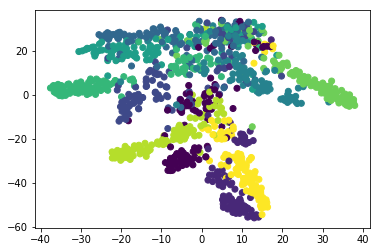

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
colors = [i*25 for i in np.argmax(y_test[0:1000], axis = 1)]
#print(colors)
embedding = TSNE(n_components=2).fit_transform(X)
plt.scatter(embedding[:,0],embedding[:,1], c = colors )

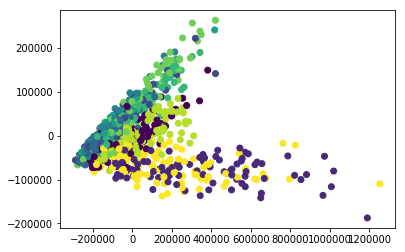

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
colors = [i*25 for i in np.argmax(y_test[0:1000], axis = 1)]
#print(colors)
embedding = PCA(n_components=2).fit_transform(X)
plt.scatter(embedding[:,0],embedding[:,1], c = colors )

In [60]:

test_pred = sess.run(pred, feed_dict={x: x_test[0:1], y_: y_test[0:1], z:z_noise, mode: EVAL}) 
test_logits = sess.run(logits, feed_dict={x: x_test[0:1], y_: y_test[0:1], z:z_noise, mode: EVAL})
print(test_logits)
print(test_pred)
print(y_test[0])

[[-29302.217  -45588.605   20297.357   44973.867     365.4592  43027.305
   32230.748  -10204.191   -5465.504  -45822.996 ]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [61]:
z_noise = np.random.normal(size = [1,32])
test_pred = sess.run(pred, feed_dict={x: x_test[0:1], y_: y_test[0:1], z:z_noise, mode: EVAL}) 
test_logits = sess.run(logits, feed_dict={x: x_test[0:1], y_: y_test[0:1], z:z_noise, mode: EVAL})
print(test_logits)
print(test_pred)
print(y_test[0])

[[-36453.89    -56723.72     25259.838    55952.402      455.04904
   53534.42     40108.74    -12701.082    -6805.332   -57009.043  ]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
